# F9 Variant Visualization

This notebook generates manuscript figures for F9 variant analysis:
- Violin plots of single-cell GFP feature distributions
- Feature correlation heatmap
- Z-score normalized feature heatmap per variant

**Data files required:**
- `f9_sc_features_minimal.parquet`: Single-cell GFP features (minimal set)
- `f9_feature_importance.parquet`: Feature importance per variant
- `f9_variant_zscore_features.parquet`: Z-score normalized variant features

Run `extract_f9_data.py` to generate these files if they don't exist.

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.colors import Normalize
import matplotlib.font_manager as fm
from scipy.stats import pearsonr, spearmanr
from adjustText import adjust_text
import re

# Font settings for publication
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['text.usetex'] = False

font_path = "../../../../utils/ARIAL.TTF"
try:
    fm.fontManager.addfont(font_path)
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams.update({
        "font.family": font_prop.get_name(),
        "font.sans-serif": ["ARIAL"],
    })
except:
    print("Font file not found, using default font")

plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
})

In [2]:
# Configuration
GENE = "F9"
OUTPUT_DIR = "../../3_outputs/pillar_manuscript_figures"
DATA_DIR = "../../3_outputs/data/F9"
TOP_NUM_FEATURES = 5  # Top N features per variant for heatmap

# Color palettes
VARIANT_COLOR = "#8B4513"  # Brown for variants
REF_COLOR = "#008080"       # Teal for reference

# ClinVar color palette (Pillar project standard)
CLINVAR_PALETTE = {
    "PLP": "#CA7682",      # Pinkish-red for pathogenic/likely pathogenic
    "BLB": "#1D7AAB",      # Blue for benign/likely benign
    "VUS": "#A0A0A0",      # Gray for VUS
    "Conflicting": "#505050",  # Dark gray for conflicting
    "Others": "#E0E0E0",   # Light gray for other
}
CLINVAR_ORDER = ["PLP", "BLB", "VUS"]

# Diverging colormap for heatmaps
CMAP = sns.diverging_palette(145, 300, s=60, as_cmap=True)

# Helper function to extract position from variant name
def extract_variant_position(variant_name):
    """Extract numeric position from variant name (e.g., 'F9_Glu73Lys' -> 73)."""
    match = re.search(r'[A-Z][a-z]{2}(\d+)[A-Z][a-z]{2}', variant_name)
    if match:
        return int(match.group(1))
    return 0

## 1. Load Data

In [3]:
# Load minimal single-cell features
sc_features = pl.read_parquet(f"{DATA_DIR}/f9_sc_features_minimal.parquet")
print(f"Single-cell features shape: {sc_features.shape}")

# Load feature importance
feat_importance = pl.read_parquet(f"{DATA_DIR}/f9_feature_importance.parquet")
print(f"Feature importance shape: {feat_importance.shape}")

# Load z-score normalized variant features
zscore_features = pl.read_parquet(f"{DATA_DIR}/f9_variant_zscore_features.parquet")
print(f"Z-score variant features shape: {zscore_features.shape}")

# Load VarChAMP integrated summary (contains imaging_score)
imaging_summary = pl.read_csv(
    "../../../../3_integrated_assay_analyses/1_inputs/VarChAMP_data_supp_mat_PP.tsv",
    separator="\t", 
    infer_schema_length=100000
).rename({
    "imaging_score": "img_pheno_score",
    "symbol": "Gene"
}).with_columns(
    # Create gene_variant column from Gene and aa_change
    (pl.col("Gene") + "_" + pl.col("aa_change")).alias("gene_variant")
)
print(f"Imaging summary shape: {imaging_summary.shape}")

Single-cell features shape: (89728, 171)
Feature importance shape: (163, 50)
Z-score variant features shape: (50, 172)
Imaging summary shape: (1407, 13)


In [4]:
# Get all F9 variants from imaging summary
f9_summary = imaging_summary.filter(pl.col("Gene") == GENE)
f9_variants = f9_summary["gene_variant"].unique().to_list()
print(f"Total F9 variants in imaging: {len(f9_variants)}")

Total F9 variants in imaging: 50


## 1.5 Imaging vs MAVE Correlation Plot

Correlation between imaging phenotype score and author-reported secretion scores from two assays:
- Heavy chain secretion
- Carboxylation-sensitive FIX-specific score

This requires joining imaging summary with pillar allele data to get Dataset and author-reported scores.

In [5]:
# Load pillar allele data with Dataset and author-reported scores
pillar_alleles = pl.read_csv(
    "../../../../1_allele_collection/3_outputs/pillar_snp_alleles.tsv",
    separator="\t",
    infer_schema_length=100000
)

# ClinVar mapping for strict pathogenicity classification (short labels)
clinvar_mapping_strict_pp_short = (
    pl.when(pl.col("clinvar_clnsig_clean_pp_strict").str.contains("Pathogenic"))
    .then(pl.lit("PLP"))
    .when(pl.col("clinvar_clnsig_clean_pp_strict").str.contains("Benign"))
    .then(pl.lit("BLB"))
    .otherwise(pl.lit("VUS"))
)

# Helper function to map chromosome number to string
def map_chr(num):
    if num == 23:
        return "X"
    elif num == 24:
        return "Y"
    elif num == 12920:
        return "MT"
    return str(num)

# Parse HGVS_c to extract chromosome, position, ref/alt alleles
# Format: NC_000023.11:g.153736195C>G
imaging_summary_parsed = imaging_summary.with_columns(
    # Extract chromosome number from NC_XXXXXX
    pl.col("HGVS_c").str.extract(r"NC_0*(\d+)\.", 1).cast(pl.Int32).alias("chr_num"),
    # Extract position (digits after "g.")
    pl.col("HGVS_c").str.extract(r":g\.(\d+)", 1).cast(pl.Float64).alias("nuc_loc"),
    # Extract reference allele (letter before ">")
    pl.col("HGVS_c").str.extract(r"(\w)>", 1).alias("ref_allele"),
    # Extract alternate allele (letter after ">")
    pl.col("HGVS_c").str.extract(r">(\w)", 1).alias("alt_allele"),
).with_columns(
    pl.col("chr_num").map_elements(map_chr, return_dtype=pl.String).str.strip_chars().alias("Chrom")
).with_columns(
    # Add short ClinVar labels (imaging_summary already has clinvar_clnsig_clean_pp_strict)
    clinvar_mapping_strict_pp_short.alias("clinvar_mapping_strict_pp_short")
)

# Join imaging summary with pillar alleles to get Dataset and auth_reported_score
imaging_with_mave = imaging_summary_parsed.join(
    pillar_alleles.select([
        "Chrom", "nuc_loc", "ref_allele", "alt_allele", 
        "Dataset", "auth_reported_score"
    ]),
    on=["Chrom", "nuc_loc", "ref_allele", "alt_allele"],
    how="inner"
)

# Filter to F9 gene
f9_mave_df = imaging_with_mave.filter(pl.col("Gene") == GENE)
print(f"F9 variants with MAVE data: {f9_mave_df.n_unique('gene_variant')}")
print(f"F9 datasets: {f9_mave_df.unique('Dataset')['Dataset'].to_list()}")

F9 variants with MAVE data: 50
F9 datasets: ['F9_Popp_2025_carboxy_gla_motif', 'F9_Popp_2025_strep_2', 'F9_Popp_2025_carboxy_F9_specific', 'F9_Popp_2025_heavy_chain', 'F9_Popp_2025_light_chain', 'F9_Popp_2025_model']


In [6]:
# Identify mislocalized variants (author-reported secretion score < 0.2)
misloc_df = f9_mave_df.filter(
    (pl.col("Dataset") == "F9_Popp_2025_heavy_chain") &
    (pl.col("auth_reported_score").cast(pl.Float64) < 0.2)
).sort("img_pheno_score", descending=True)

misloc_variants = misloc_df["gene_variant"].unique().to_list()

# Sort variants by amino acid position
misloc_variants_sorted = sorted(misloc_variants, key=extract_variant_position)

print(f"Mislocalized variants: {len(misloc_variants)}")
print("Variants:", ", ".join([v.split("_")[1] for v in misloc_variants_sorted]))

# Final variant order for visualization (reference first, then sorted variants)
sorted_alleles_pos = [GENE] + misloc_variants_sorted

Mislocalized variants: 14
Variants: Cys28Arg, Tyr161Cys, Asn166Tyr, Cys170Tyr, Arg294Gln, Ile316Thr, Pro333Leu, Cys335Trp, Cys335Tyr, Val374Phe, Phe395Ile, Cys396Ser, Ala397Pro, Trp453Arg


In [7]:
def plot_mave_imaging_correlation(
    df, 
    studies, 
    feat="img_pheno_score",
    clinvar_col="clinvar_mapping_strict_pp_short",
    highlight_variants=None,
    output_name=None
):
    """
    Plot correlation between imaging phenotype score and author-reported scores.
    
    Parameters
    ----------
    df : pl.DataFrame
        Imaging summary dataframe with ClinVar annotations
    studies : list of tuples
        List of (study_name, y_label) tuples
    feat : str
        Feature column for x-axis (imaging score)
    clinvar_col : str
        Column for ClinVar classification coloring
    highlight_variants : list, optional
        Variant substrings to label on the plot
    output_name : str, optional
        If provided, save figure to OUTPUT_DIR
    """
    n_studies = len(studies)
    fig, axes = plt.subplots(1, n_studies, figsize=(4.5 * n_studies, 4))
    if n_studies == 1:
        axes = [axes]
    
    for j, (study, ylabel) in enumerate(studies):
        # Filter to study
        study_df = df.filter(pl.col("Dataset") == study).with_columns(
            pl.col("auth_reported_score").cast(pl.Float64)
        )
        
        # Prepare plot data
        plot_data = study_df.with_columns(
            pl.col(clinvar_col).fill_null("Other").alias(clinvar_col)
        ).to_pandas()
        
        # Scatter plot with ClinVar coloring
        sns.scatterplot(
            data=plot_data,
            x=feat,
            y="auth_reported_score",
            ax=axes[j],
            hue=clinvar_col,
            palette=CLINVAR_PALETTE,
            hue_order=CLINVAR_ORDER,
            s=50,
            alpha=0.8
        )
        
        # Regression line
        sns.regplot(
            data=plot_data,
            x=feat,
            y="auth_reported_score",
            ax=axes[j],
            scatter=False,
            color="black",
            line_kws={"linewidth": 1.5}
        )
        
        # Add labels for highlighted variants
        if highlight_variants:
            texts = []
            for _, row in plot_data.iterrows():
                if pd.notna(row["auth_reported_score"]) and pd.notna(row[feat]):
                    if any(v in row["gene_variant"] for v in highlight_variants):
                        text = axes[j].annotate(
                            row["gene_variant"].split("_")[-1],
                            (row[feat], row["auth_reported_score"]),
                            fontsize=9,
                            color="black"
                        )
                        texts.append(text)
            
            if texts:
                adjust_text(
                    texts,
                    ax=axes[j],
                    arrowprops=dict(arrowstyle="->", color="gray", alpha=0.5),
                    expand_text=(1.2, 1.4),
                    expand_points=(1.2, 1.4),
                    force_text=(0.5, 0.5),
                    force_points=(0.5, 0.5),
                    lim=200
                )
        
        # Pearson correlation
        mask = plot_data["auth_reported_score"].notna() & plot_data[feat].notna()
        if mask.sum() > 2:
            rho, p_val = pearsonr(
                plot_data.loc[mask, "auth_reported_score"],
                plot_data.loc[mask, feat]
            )
            axes[j].text(
                0.85, 0.97,
                f"$r$ = {rho:.2f}\np = {p_val:.3e}",
                fontsize=10,
                transform=axes[j].transAxes,
                verticalalignment="top",
                horizontalalignment="center",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.6)
            )
        
        # Formatting
        axes[j].set_ylabel(ylabel)
        axes[j].set_xlabel("Imaging phenotype score")
        axes[j].set_ylim(-0.08, 1.4)
        axes[j].set_xlim(0.5, 1.01)
        
        # Legend only on first panel
        if j == 0:
            axes[j].legend(fontsize=10, loc="lower left", title="ClinVar")
        else:
            axes[j].get_legend().remove()
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25)
    
    if output_name:
        plt.savefig(f"{OUTPUT_DIR}/{output_name}.svg", dpi=400, transparent=True, bbox_inches="tight")
    
    # plt.show()
    return fig

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


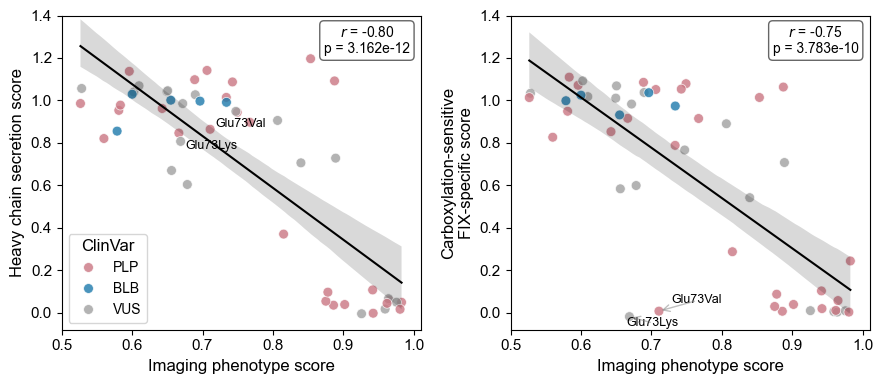

In [8]:
# Define F9 studies with their y-axis labels
F9_STUDIES = [
    ("F9_Popp_2025_heavy_chain", "Heavy chain secretion score"),
    ("F9_Popp_2025_carboxy_F9_specific", "Carboxylation-sensitive\nFIX-specific score"),
]

# Plot correlation with optional variant highlighting
plot_mave_imaging_correlation(
    df=f9_mave_df,
    studies=F9_STUDIES,
    feat="img_pheno_score",
    clinvar_col="clinvar_mapping_strict_pp_short",
    highlight_variants=["Glu73"],  # Highlight specific variants
    # output_name="F9_MAVE_Img_Corr"
)

## 2. Violin Plots

In [9]:
def create_violin_plot(df, features, variant_order, output_name=None, figsize=(8, None)):
    """Create violin plots for specified features across variants."""
    n_features = len(features)
    if figsize[1] is None:
        figsize = (figsize[0], n_features * 2.3)
    
    fig, axes = plt.subplots(n_features, 1, figsize=figsize, sharex=True)
    if n_features == 1:
        axes = [axes]
    
    color_palette = {
        key: (VARIANT_COLOR if key != GENE else REF_COLOR)
        for key in variant_order
    }
    
    for i, feat in enumerate(features):
        df_plot = df.filter(pl.col("Metadata_gene_allele").is_in(variant_order))
        
        sns.violinplot(
            data=df_plot.to_pandas(),
            x="Metadata_gene_allele",
            y=feat,
            ax=axes[i],
            hue="Metadata_gene_allele",
            palette=color_palette,
            alpha=0.7,
            order=variant_order,
            cut=0,
            legend=False
        )
        
        # Format y-axis label
        if "Ratio" in feat:
            ylabel = "Nucleus-to-Cytoplasm\nExpression\nRatio"
        else:
            parts = feat.split('_')
            ylabel = f"{parts[0]}\n{'_'.join(parts[1:3])}\n{'_'.join(parts[3:])}\n(A.U.)"
        axes[i].set_ylabel(ylabel, fontsize=10)
        axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=11)
    
    # Format x-axis
    axes[-1].set_xlabel("", fontsize=8)
    axes[-1].set_xticklabels(
        [x.get_text().split('_')[-1] if x.get_text() != GENE else "FIX" 
         for x in axes[-1].get_xticklabels()],
        fontsize=10, rotation=25, ha='right'
    )
    
    plt.subplots_adjust(hspace=0.12)
    
    if output_name:
        plt.savefig(f"{OUTPUT_DIR}/{output_name}.svg", dpi=400, transparent=True, bbox_inches='tight')
    
    # plt.show()
    return fig

<ipython-input-9-dab62dac3c95>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=11)
<ipython-input-9-dab62dac3c95>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=11)
<ipython-input-9-dab62dac3c95>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[-1].set_xticklabels(


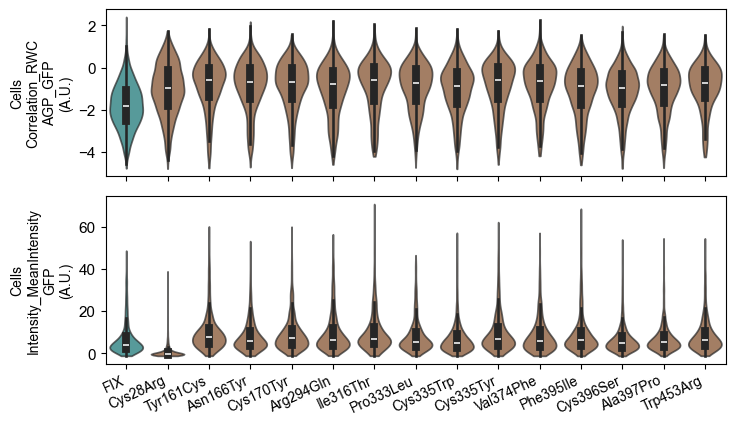

In [10]:
# Main figure: Key biological features
main_features = [
    "Cells_Correlation_RWC_AGP_GFP",
    "Cells_Intensity_MeanIntensity_GFP",
]

create_violin_plot(
    sc_features, main_features, sorted_alleles_pos, 
    # output_name="F9_sc_gfp_feat_dist_main"
)

<ipython-input-9-dab62dac3c95>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=11)
<ipython-input-9-dab62dac3c95>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=11)
<ipython-input-9-dab62dac3c95>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=11)
<ipython-input-9-dab62dac3c95>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[-1].set_xticklabels(


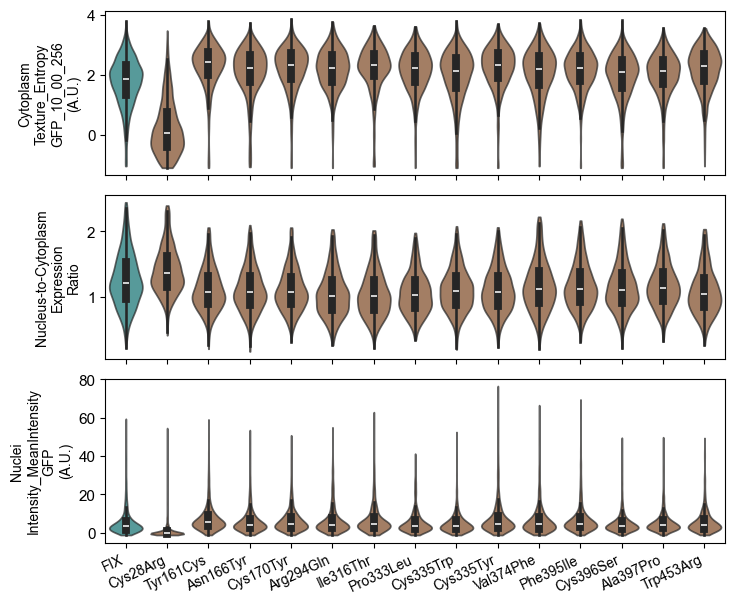

In [11]:
# Supplementary figure: Additional features including Nuc2Cyto ratio
supp_features = [
    "Cytoplasm_Texture_Entropy_GFP_10_00_256",
    "Nuc2Cyto_Ratio_Mean",
    "Nuclei_Intensity_MeanIntensity_GFP"
]

# Filter outliers for Nuc2Cyto_Ratio_Mean using IQR method
value_column = "Nuc2Cyto_Ratio_Mean"
group_column = "Metadata_gene_allele"

sc_features_filtered = sc_features.filter(
    pl.col("Metadata_gene_allele").is_in(sorted_alleles_pos)
).with_columns(
    q1=pl.col(value_column).quantile(0.25).over(group_column),
    q3=pl.col(value_column).quantile(0.75).over(group_column)
).with_columns(
    iqr=(pl.col('q3') - pl.col('q1')),
).with_columns(
    lower_bound=(pl.col('q1') - 1.5 * pl.col('iqr')),
    upper_bound=(pl.col('q3') + 1.5 * pl.col('iqr'))
).filter(
    (pl.col(value_column) >= pl.col('lower_bound')) &
    (pl.col(value_column) <= pl.col('upper_bound'))
)

create_violin_plot(
    sc_features_filtered, supp_features, sorted_alleles_pos, 
    # output_name="F9_sc_gfp_feat_dist_supp"
)

## 3. Feature Correlation Heatmap

In [12]:
# Get top features for mislocalized variants
top_feat_per_variant = []
for variant in misloc_variants:
    if variant in feat_importance.columns:
        top_feats = feat_importance.filter(
            pl.col(variant).is_in(pl.col(variant).top_k(TOP_NUM_FEATURES))
        ).select(["cp_feature", variant])
        top_feat_per_variant.append(top_feats)

# Combine all top features
result_df = feat_importance.select("cp_feature").unique().sort("cp_feature")
for i, variant in enumerate(misloc_variants):
    if i < len(top_feat_per_variant):
        result_df = result_df.join(top_feat_per_variant[i], on="cp_feature", how="left")

misloc_var_top_feat_df = result_df.filter(
    ~pl.all_horizontal(pl.all().exclude("cp_feature").is_null())
)
get_top_n_feats_misloc_alleles = misloc_var_top_feat_df["cp_feature"].to_list()

print(f"Top features for heatmap: {len(get_top_n_feats_misloc_alleles)}")

Top features for heatmap: 20


/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


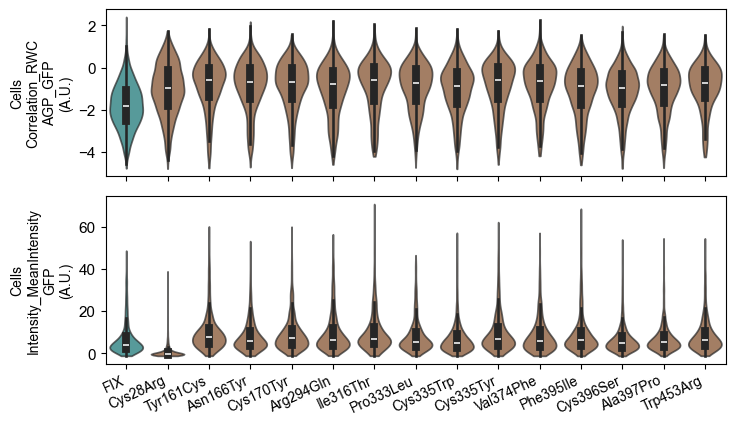

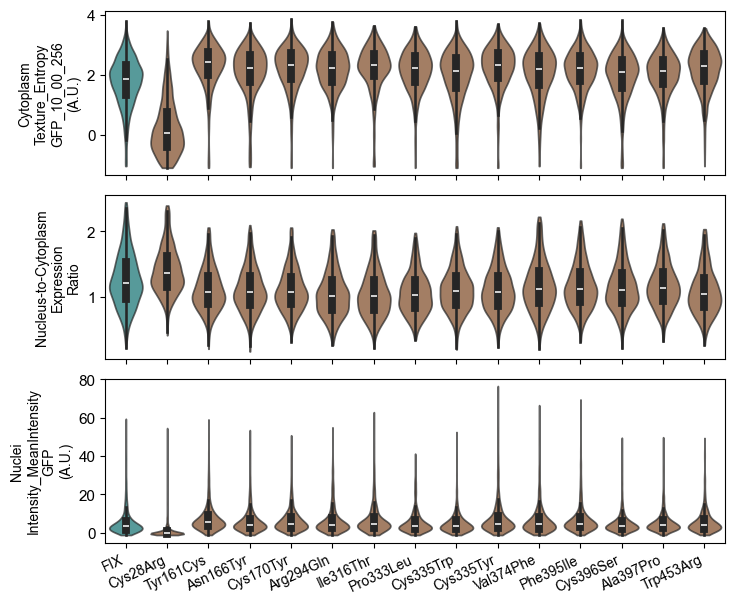

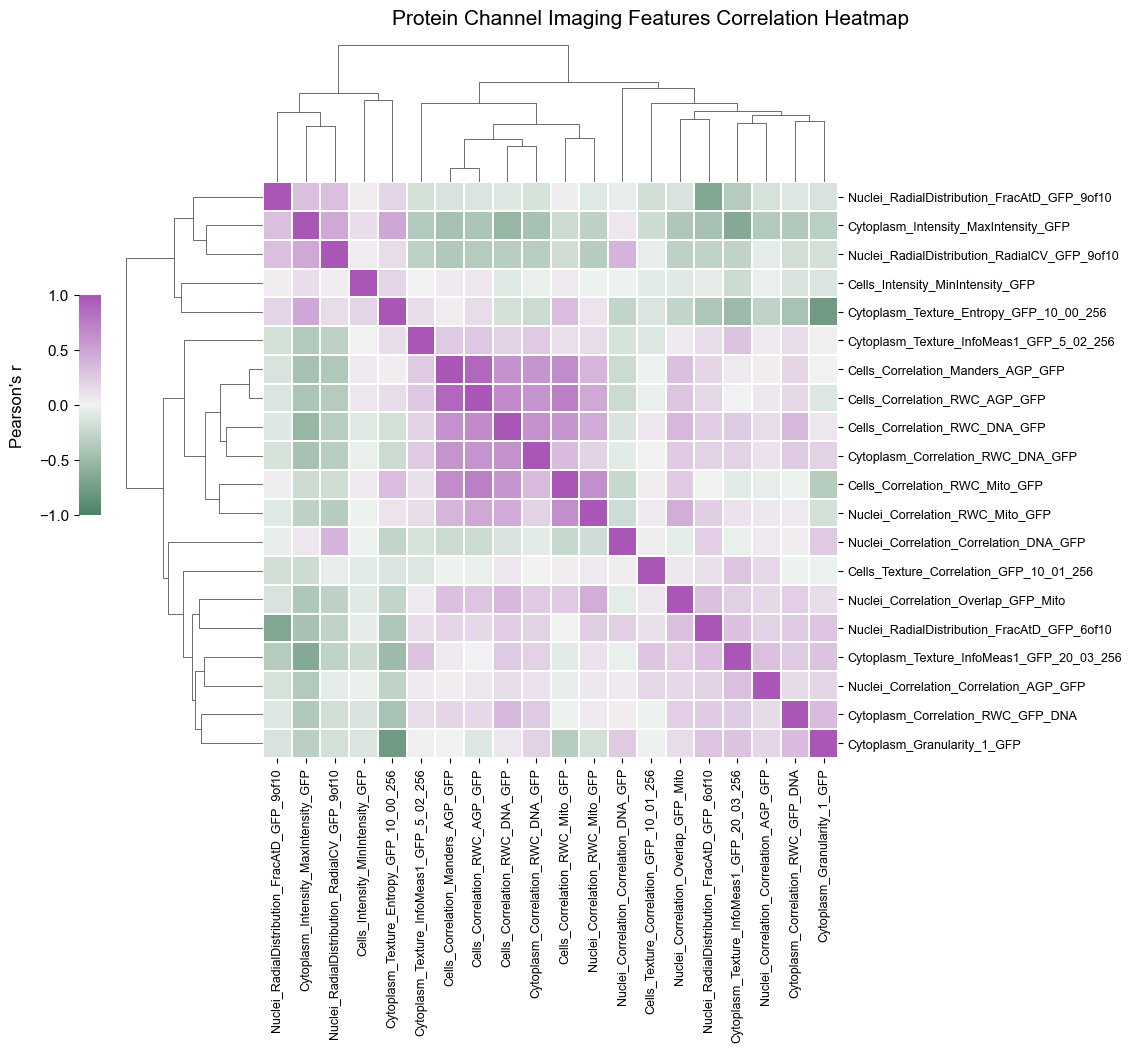

Feature order from clustering: 20 features


In [41]:
# Feature correlation heatmap
# Filter to features that exist in single-cell data
features_present = [f for f in get_top_n_feats_misloc_alleles if f in sc_features.columns]

corr_df = sc_features.filter(
    pl.col("Metadata_gene_allele").is_in(sorted_alleles_pos)
).select(features_present).to_pandas().corr(method="pearson")

g = sns.clustermap(
    corr_df,
    cmap=CMAP, center=0,
    vmin=-1, vmax=1,
    cbar_pos=(-.02, 0.55, 0.02, 0.2),
    yticklabels=1, xticklabels=1,
    square=True,
    figsize=(11, 11),
    linewidth=.05,
)
g.fig.suptitle("Protein Channel Imaging Features Correlation Heatmap", fontsize=15, y=1.01)
g.cax.yaxis.set_label_position('left')
g.cax.yaxis.set_ticks_position('left')
g.cax.set_ylabel(r"Pearson's r", labelpad=10)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)
plt.show()

# Save column order for z-score heatmap
col_order = list(corr_df.columns[g.dendrogram_col.reordered_ind])
print(f"Feature order from clustering: {len(col_order)} features")

## 4. Z-Score Normalized Variant Feature Heatmap

In [42]:
# Prepare z-score data for heatmap
# Sort by imaging phenotype score
zscore_sorted = zscore_features.sort("Metadata_img_pheno_score", descending=True)

# Get feature columns (non-metadata)
feature_cols = [c for c in zscore_sorted.columns if "Metadata" not in c]

# Filter to features in col_order that exist in zscore data
features_for_heatmap = [f for f in col_order if f in feature_cols]

# Prepare data as pandas DataFrame
heatmap_df = zscore_sorted.filter(
    pl.col("Metadata_gene_allele").is_in(misloc_variants)
).to_pandas().set_index("Metadata_gene_allele")[features_for_heatmap]

print(f"Heatmap data shape: {heatmap_df.shape}")

Heatmap data shape: (14, 20)


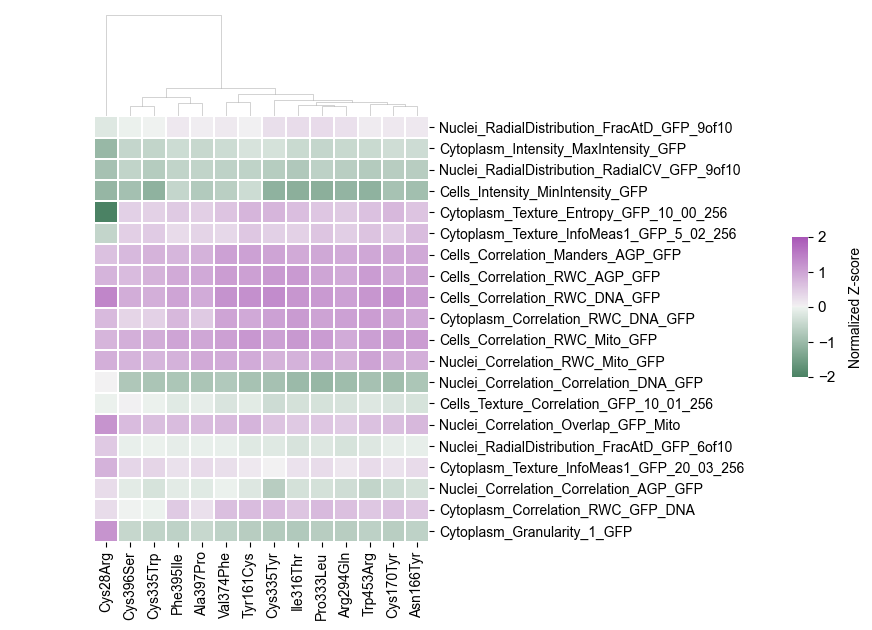

Clustered variant order: ['F9', 'Cys28Arg', 'Cys396Ser', 'Cys335Trp', 'Phe395Ile', 'Ala397Pro', 'Val374Phe', 'Tyr161Cys', 'Cys335Tyr', 'Ile316Thr', 'Pro333Leu', 'Arg294Gln', 'Trp453Arg', 'Cys170Tyr', 'Asn166Tyr']


In [46]:
# Create z-score heatmap with clustered columns
g_final = sns.clustermap(
    data=heatmap_df.loc[misloc_variants, features_for_heatmap].T,
    cmap=CMAP, center=0,
    vmin=-2, vmax=2,
    row_cluster=False,  # Keep feature order from correlation clustering
    col_cluster=True,   # Cluster variants
    cbar_pos=(1, 0.45, 0.02, 0.2),
    yticklabels=1, xticklabels=1,
    figsize=(8, 7),
    tree_kws={'alpha': .3},
    linewidth=.1,
    colors_ratio=0.05
)

# Format labels
g_final.cax.set_ylabel('Normalized Z-score', labelpad=10, fontsize=10)
g_final.ax_heatmap.set_xlabel('')
g_final.ax_heatmap.set_ylabel('')
g_final.ax_heatmap.set_xticklabels(
    [x.get_text().split('_')[1] for x in g_final.ax_heatmap.get_xticklabels()], 
    fontsize=10
)
g_final.ax_heatmap.set_yticklabels(g_final.ax_heatmap.get_yticklabels(), fontsize=10)

# plt.tight_layout()
# g_final.savefig(f"{OUTPUT_DIR}/F9_variant_heatmap.svg", dpi=400, transparent=True, bbox_inches='tight')
plt.show()

# Get final variant order from clustering
new_allele_order = [GENE] + list(heatmap_df.loc[misloc_variants].index[g_final.dendrogram_col.reordered_ind])
print(f"Clustered variant order: {[v.split('_')[-1] for v in new_allele_order]}")

## Summary

Generated figures:
1. `F9_MAVE_Img_Corr.svg` - Imaging vs MAVE correlation plots (heavy chain & carboxylation scores)
2. `F9_sc_gfp_feat_dist_main.svg` - Main violin plots (key biological features)
3. `F9_sc_gfp_feat_dist_supp.svg` - Supplementary violin plots (additional features)
4. `F9_variant_heatmap.svg` - Z-score normalized feature heatmap for mislocalized variants

**Data files used:**
- `f9_sc_features_minimal.parquet` (51.76 MB) - Single-cell features
- `f9_feature_importance.parquet` (0.03 MB) - Feature importance
- `f9_variant_zscore_features.parquet` (0.11 MB) - Z-score variant features

Total data size: ~52 MB (suitable for GitHub)